In [29]:
import os
import torch
import cv2
import supervision as sv
import numpy as np

Be sure to pip install supervision and pip install opencv-python if you do not have them already.

# Install the SAM module from Github

In [14]:
#!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

# Install some other dependencies

In [15]:
#!pip install -q jupyter_bbox_widget

## Download model weights and save to weights directory. If it doesn't work here, try downloading it directly in the terminal.

In [16]:
#!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P /weights

## Load in SAM

!!torchvision package is also required, so make sure to pip install torchvision. If it results in reinstalling torch, make sure to restart Kernel for the following to work.!!

In [3]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# I'm not sure how it works, but this is allegedly how we load in the model.

In [4]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [7]:
CHECKPOINT_PATH = './weights/sam_vit_h_4b8939.pth'

In [8]:
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

# Use SAM to automatically generate masks (probably not what we want to do)

In [9]:
mask_generator = SamAutomaticMaskGenerator(sam)

# Load in test image. Be sure to change image path for your PC

In [43]:
test_image_path = '../../Screenshot 2024-02-10 at 10.43.56 AM.png'
GSI_image_test_path = '../../H1-No23-572/val/32.png'

In [12]:
image_bgr = cv2.imread(test_image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

In [13]:
type(image_rgb)

numpy.ndarray

cv2.imread() returns a numpy array in bgr format. We used cvtColor() to transform it back to rgb format.

In [17]:
sam_result = mask_generator.generate(image_rgb)
type(sam_result)

list

In [19]:
len(sam_result)

289

It looks like the model generated 289 masks for this particular image.

In [20]:
sam_result[0]

{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 36638,
 'bbox': [568, 456, 173, 278],
 'predicted_iou': 1.0209002494812012,
 'point_coords': [[602.34375, 685.78125]],
 'stability_score': 0.965196430683136,
 'crop_box': [0, 0, 2570, 1330]}

Let's look at what masks the model generated using the supervision library.

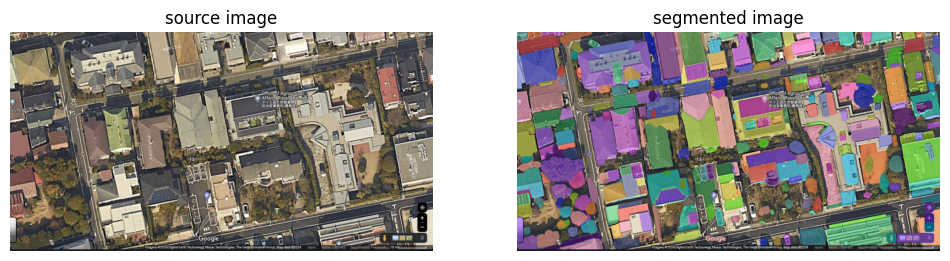

In [21]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

# Generate Segmentation with Manual Bounding Box

・The SamPredictor class allows us to prompt the model to look for a specific bounding region that we specify using the set_image method.

In [22]:
mask_predictor = SamPredictor(sam)

In [23]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

## Use mouse to draw a box around the region we want to mask and click submit.

In [37]:
IS_COLAB = False #<- change to True if running in Google Collab

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(test_image_path)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

Widget.bboxes gives us the x/y coordinates of the box we just drew.

In [38]:
widget.bboxes

[{'x': 1679, 'y': 366, 'width': 615, 'height': 697, 'label': ''}]

Now let's generate some masks using the sample box we made above.

In [39]:
# default_box to be used if no box is given in image above.
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [40]:
image_bgr = cv2.imread(test_image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

# Let's view the masking results using the supervision library again

/var/folders/vn/13psflc51r9239vr17gr6rxw0000gn/T/ipykernel_66503/1852450646.py:1: DeprecationWarning: red is deprecated: `Color.red()` is deprecated and will be removed in `supervision-0.20.0`. Use `Color.RED` instead.
  box_annotator = sv.BoxAnnotator(color=sv.Color.red())
/var/folders/vn/13psflc51r9239vr17gr6rxw0000gn/T/ipykernel_66503/1852450646.py:2: DeprecationWarning: red is deprecated: `Color.red()` is deprecated and will be removed in `supervision-0.20.0`. Use `Color.RED` instead.
  mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup=sv.ColorLookup.INDEX)


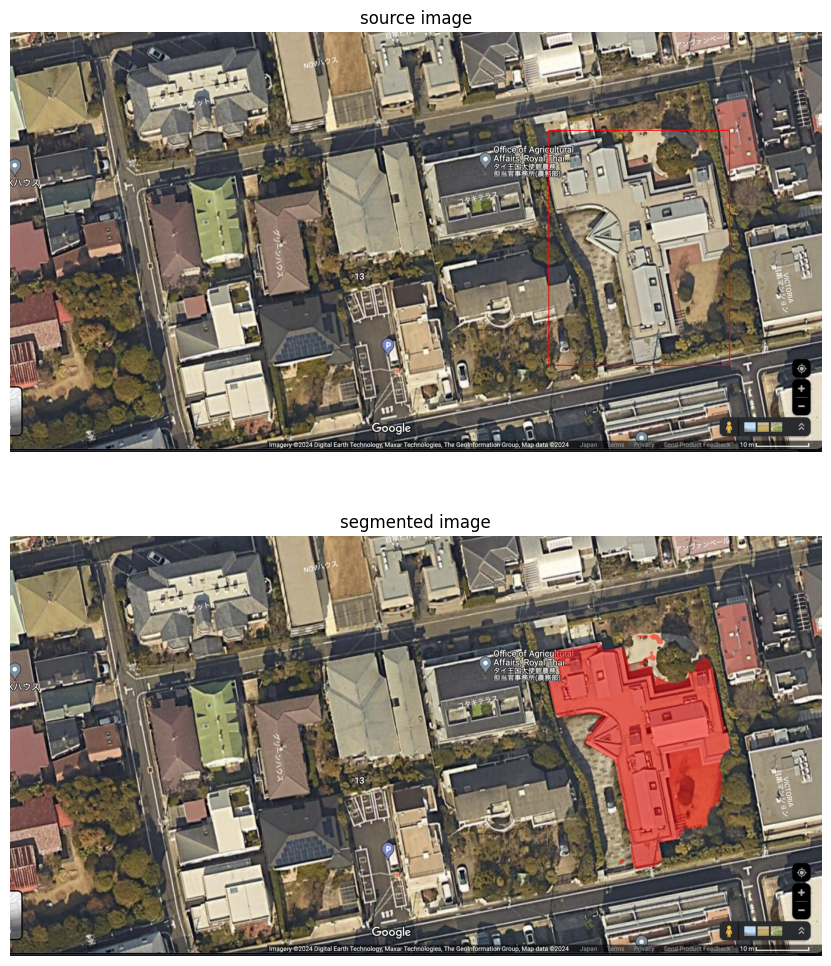

In [41]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(2, 1),
    titles=['source image', 'segmented image'])

# Let's see what the model does when given our GSI validation data.

In [44]:
image_bgr = cv2.imread(GSI_image_test_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

In [45]:
sam_result = mask_generator.generate(image_rgb)

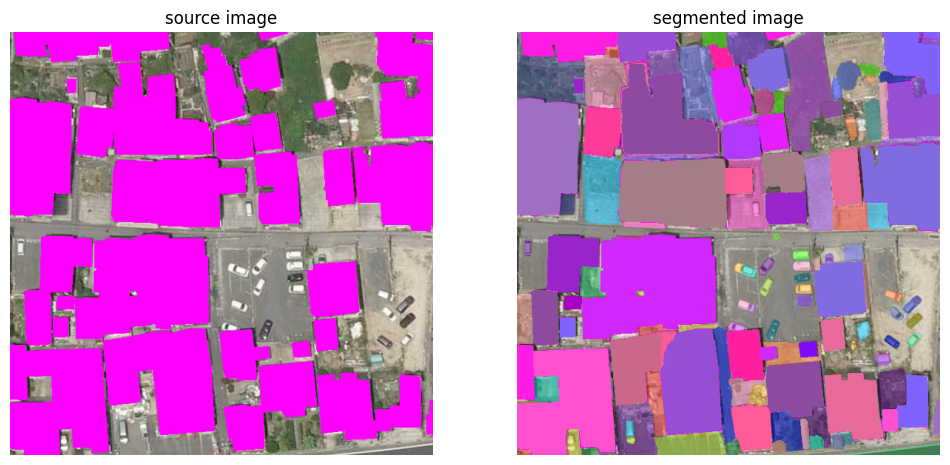

In [46]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

It looks like the model is fairly decent at identifying the pre-labeled boxes. But how do we use this????